<a href="https://colab.research.google.com/github/ericburdett/hwr/blob/master/notebook-tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple HWR - TensorFlow

A Handwriting Recognition implementation adapted from Flor.
* [Blog Post](https://medium.com/@arthurflor23/handwritten-text-recognition-using-tensorflow-2-0-f4352b7afe16)
* [GitHub](https://github.com/arthurflor23/handwritten-text-recognition)

### Imports and Setup

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.constraints as C
from tensorflow.keras import Model
from tensorflow.keras import backend as K

# Data Structures
import pandas as pd
import numpy as np
import json
import csv
import html
import numba as nb

# Python
import os
import gc
import string
import re

# Match
import editdistance as ed

# Image/Plotting
import cv2
from matplotlib import pyplot as plt
from PIL import Image

# Colab
from google.colab import drive
drive.mount('/content/drive')

# Debugging
from tqdm import tqdm
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "drive/My Drive/datasets/rimes-line-level.zip" "/content"
!cp "drive/My Drive/datasets/iam-line-level.zip" "/content"

!unzip -q rimes-line-level.zip -d rimes
!unzip -q iam-line-level.zip -d iam
!rm iam-line-level.zip
!rm rimes-line-level.zip

!wget -q https://raw.githubusercontent.com/ericburdett/cs601r-dl/master/char_set.json

### Preprocessing Code - Taken from arthurflor23/handwritten-text-recognition

[Reference](https://github.com/arthurflor23/handwritten-text-recognition/blob/master/src/data/preproc.py)

In [0]:
"""
Data preproc functions:
    adjust_to_see: adjust image to better visualize (rotate and transpose)
    augmentation: apply variations to a list of images
    normalization: apply normalization and variations on images (if required)
    preprocess: main function for preprocess.
        Make the image:
            illumination_compensation: apply illumination regularitation
            remove_cursive_style: remove cursive style from image (if necessary)
            sauvola: apply sauvola binarization
    text_standardize: preprocess and standardize sentence
    generate_multigrams: generate n-grams of the sentence
"""

def adjust_to_see(img):
    """Rotate and transpose to image visualize (cv2 method or jupyter notebook)"""

    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), -90, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    img = cv2.warpAffine(img, M, (nW + 1, nH + 1))
    img = cv2.warpAffine(img.transpose(), M, (nW, nH))

    return img


def augmentation(imgs,
                 rotation_range=0,
                 scale_range=0,
                 height_shift_range=0,
                 width_shift_range=0,
                 dilate_range=1,
                 erode_range=1):
    """Apply variations to a list of images (rotate, width and height shift, scale, erode, dilate)"""

    imgs = imgs.astype(np.float32)
    _, h, w = imgs.shape

    dilate_kernel = np.ones((int(np.random.uniform(1, dilate_range)),), np.uint8)
    erode_kernel = np.ones((int(np.random.uniform(1, erode_range)),), np.uint8)
    height_shift = np.random.uniform(-height_shift_range, height_shift_range)
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - scale_range, 1)
    width_shift = np.random.uniform(-width_shift_range, width_shift_range)

    trans_map = np.float32([[1, 0, width_shift * w], [0, 1, height_shift * h]])
    rot_map = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)

    trans_map_aff = np.r_[trans_map, [[0, 0, 1]]]
    rot_map_aff = np.r_[rot_map, [[0, 0, 1]]]
    affine_mat = rot_map_aff.dot(trans_map_aff)[:2, :]

    for i in range(len(imgs)):
        imgs[i] = cv2.warpAffine(imgs[i], affine_mat, (w, h), flags=cv2.INTER_NEAREST, borderValue=255)
        imgs[i] = cv2.erode(imgs[i], erode_kernel, iterations=1)
        imgs[i] = cv2.dilate(imgs[i], dilate_kernel, iterations=1)

    return imgs


def normalization(imgs):
    """Normalize list of images"""

    imgs = np.asarray(imgs).astype(np.float32)
    _, h, w = imgs.shape

    for i in range(len(imgs)):
        m, s = cv2.meanStdDev(imgs[i])
        imgs[i] = imgs[i] - m[0][0]
        imgs[i] = imgs[i] / s[0][0] if s[0][0] > 0 else imgs[i]

    return np.expand_dims(imgs, axis=-1)


"""
Preprocess metodology based in:
    H. Scheidl, S. Fiel and R. Sablatnig,
    Word Beam Search: A Connectionist Temporal Classification Decoding Algorithm, in
    16th International Conference on Frontiers in Handwriting Recognition, pp. 256-258, 2018.
"""


def preprocess(img, input_size):
    """Make the process with the `input_size` to the scale resize"""

    if isinstance(img, str):
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

    if isinstance(img, tuple):
        image, boundbox = img
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

        for i in range(len(boundbox)):
            if isinstance(boundbox[i], float):
                total = len(img) if i < 2 else len(img[0])
                boundbox[i] = int(total * boundbox[i])

        img = np.asarray(img[boundbox[0]:boundbox[1], boundbox[2]:boundbox[3]], dtype=np.uint8)

    wt, ht, _ = input_size
    h, w = np.asarray(img).shape
    f = max((w / wt), (h / ht))

    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))
    img = cv2.resize(img, new_size)

    _, binary = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)

    if np.sum(img) * 0.8 > np.sum(binary):
        img = illumination_compensation(img)

    img = remove_cursive_style(img)

    target = np.ones([ht, wt], dtype=np.uint8) * 255
    target[0:new_size[1], 0:new_size[0]] = img
    img = cv2.transpose(target)

    return img


"""
Illumination Compensation based in:
    K.-N. Chen, C.-H. Chen, C.-C. Chang,
    Efficient illumination compensation techniques for text images, in
    Digital Signal Processing, 22(5), pp. 726-733, 2012.
"""


def illumination_compensation(img):
    """Illumination compensation technique for text image"""

    def scale(img):
        s = np.max(img) - np.min(img)
        res = img / s
        res -= np.min(res)
        res *= 255
        return res

    img = img.astype(np.float32)
    height, width = img.shape
    sqrt_hw = np.sqrt(height * width)

    bins = np.arange(0, 300, 10)
    bins[26] = 255
    hp = np.histogram(img, bins)
    for i in range(len(hp[0])):
        if hp[0][i] > sqrt_hw:
            hr = i * 10
            break

    np.seterr(divide='ignore', invalid='ignore')
    cei = (img - (hr + 50 * 0.3)) * 2
    cei[cei > 255] = 255
    cei[cei < 0] = 0

    m1 = np.asarray([-1, 0, 1, -2, 0, 2, -1, 0, 1]).reshape((3, 3))
    m2 = np.asarray([-2, -1, 0, -1, 0, 1, 0, 1, 2]).reshape((3, 3))
    m3 = np.asarray([-1, -2, -1, 0, 0, 0, 1, 2, 1]).reshape((3, 3))
    m4 = np.asarray([0, 1, 2, -1, 0, 1, -2, -1, 0]).reshape((3, 3))

    eg1 = np.abs(cv2.filter2D(img, -1, m1))
    eg2 = np.abs(cv2.filter2D(img, -1, m2))
    eg3 = np.abs(cv2.filter2D(img, -1, m3))
    eg4 = np.abs(cv2.filter2D(img, -1, m4))

    eg_avg = scale((eg1 + eg2 + eg3 + eg4) / 4)

    h, w = eg_avg.shape
    eg_bin = np.zeros((h, w))
    eg_bin[eg_avg >= 30] = 255

    h, w = cei.shape
    cei_bin = np.zeros((h, w))
    cei_bin[cei >= 60] = 255

    h, w = eg_bin.shape
    tli = 255 * np.ones((h, w))
    tli[eg_bin == 255] = 0
    tli[cei_bin == 255] = 0

    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(tli, kernel, iterations=1)
    int_img = np.asarray(cei)

    estimate_light_distribution(width, height, erosion, cei, int_img)

    mean_filter = 1 / 121 * np.ones((11, 11), np.uint8)
    ldi = cv2.filter2D(scale(int_img), -1, mean_filter)

    result = np.divide(cei, ldi) * 260
    result[erosion != 0] *= 1.5
    result[result < 0] = 0
    result[result > 255] = 255

    return np.asarray(result, dtype=np.uint8)


@nb.jit(nopython=True)
def estimate_light_distribution(width, height, erosion, cei, int_img):
    """Light distribution performed by numba (thanks @Sundrops)"""

    for y in range(width):
        for x in range(height):
            if erosion[x][y] == 0:
                i = x

                while i < erosion.shape[0] and erosion[i][y] == 0:
                    i += 1

                end = i - 1
                n = end - x + 1

                if n <= 30:
                    h, e = [], []

                    for k in range(5):
                        if x - k >= 0:
                            h.append(cei[x - k][y])

                        if end + k < cei.shape[0]:
                            e.append(cei[end + k][y])

                    mpv_h, mpv_e = max(h), max(e)

                    for m in range(n):
                        int_img[x + m][y] = mpv_h + (m + 1) * ((mpv_e - mpv_h) / n)

                x = end
                break


"""
Deslating image process based in,
    A. Vinciarelli and J. Luettin,
    A New Normalization Technique for Cursive Handwritten Wrods, in
    Pattern Recognition, 22, 2001.
"""


def remove_cursive_style(img):
    """Remove cursive writing style from image with deslanting algorithm"""

    def calc_y_alpha(vec):
        indices = np.where(vec > 0)[0]
        h_alpha = len(indices)

        if h_alpha > 0:
            delta_y_alpha = indices[h_alpha - 1] - indices[0] + 1

            if h_alpha == delta_y_alpha:
                return h_alpha * h_alpha
        return 0

    alpha_vals = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
    rows, cols = img.shape
    results = []

    ret, otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = otsu if ret < 127 else sauvola(img, (int(img.shape[0] / 2), int(img.shape[0] / 2)), 127, 1e-2)

    for alpha in alpha_vals:
        shift_x = max(-alpha * rows, 0.)
        size = (cols + int(np.ceil(abs(alpha * rows))), rows)
        transform = np.asarray([[1, alpha, shift_x], [0, 1, 0]], dtype=np.float)

        shear_img = cv2.warpAffine(binary, transform, size, cv2.INTER_NEAREST)
        sum_alpha = 0
        sum_alpha += np.apply_along_axis(calc_y_alpha, 0, shear_img)
        results.append([np.sum(sum_alpha), size, transform])

    result = sorted(results, key=lambda x: x[0], reverse=True)[0]
    warp = cv2.warpAffine(img, result[2], result[1], borderValue=255)

    return cv2.resize(warp, dsize=(cols, rows))


"""
Sauvola binarization based in,
    J. Sauvola, T. Seppanen, S. Haapakoski, M. Pietikainen,
    Adaptive Document Binarization, in IEEE Computer Society Washington, 1997.
"""


def sauvola(img, window, thresh, k):
    """Sauvola binarization"""

    rows, cols = img.shape
    pad = int(np.floor(window[0] / 2))
    sum2, sqsum = cv2.integral2(
        cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_CONSTANT))

    isum = sum2[window[0]:rows + window[0], window[1]:cols + window[1]] + \
        sum2[0:rows, 0:cols] - \
        sum2[window[0]:rows + window[0], 0:cols] - \
        sum2[0:rows, window[1]:cols + window[1]]

    isqsum = sqsum[window[0]:rows + window[0], window[1]:cols + window[1]] + \
        sqsum[0:rows, 0:cols] - \
        sqsum[window[0]:rows + window[0], 0:cols] - \
        sqsum[0:rows, window[1]:cols + window[1]]

    ksize = window[0] * window[1]
    mean = isum / ksize
    std = (((isqsum / ksize) - (mean**2) / ksize) / ksize) ** 0.5
    threshold = (mean * (1 + k * (std / thresh - 1))) * (mean >= 100)

    return np.asarray(255 * (img >= threshold), 'uint8')


"""
DeepSpell based text cleaning process.
    Tal Weiss.
    Deep Spelling.
    Medium: https://machinelearnings.co/deep-spelling-9ffef96a24f6#.2c9pu8nlm
    Github: https://github.com/MajorTal/DeepSpell
"""

RE_DASH_FILTER = re.compile(r'[\-\˗\֊\‐\‑\‒\–\—\⁻\₋\−\﹣\－]', re.UNICODE)
RE_APOSTROPHE_FILTER = re.compile(r'&#39;|[ʼ՚＇‘’‛❛❜ߴߵ`‵´ˊˋ{}{}{}{}{}{}{}{}{}]'.format(
    chr(768), chr(769), chr(832), chr(833), chr(2387),
    chr(5151), chr(5152), chr(65344), chr(8242)), re.UNICODE)
RE_RESERVED_CHAR_FILTER = re.compile(r'[¶¤«»]', re.UNICODE)
RE_LEFT_PARENTH_FILTER = re.compile(r'[\(\[\{\⁽\₍\❨\❪\﹙\（]', re.UNICODE)
RE_RIGHT_PARENTH_FILTER = re.compile(r'[\)\]\}\⁾\₎\❩\❫\﹚\）]', re.UNICODE)
RE_BASIC_CLEANER = re.compile(r'[^\w\s{}]'.format(re.escape(string.punctuation)), re.UNICODE)

LEFT_PUNCTUATION_FILTER = """!%&),.:;<=>?@\\]^_`|}~"""
RIGHT_PUNCTUATION_FILTER = """"(/<=>@[\\^_`{|~"""
NORMALIZE_WHITESPACE_REGEX = re.compile(r'[^\S\n]+', re.UNICODE)


def text_standardize(text):
    """Organize/add spaces around punctuation marks"""

    if text is None:
        return ""

    text = html.unescape(text).replace("\\n", "").replace("\\t", "")

    text = RE_RESERVED_CHAR_FILTER.sub("", text)
    text = RE_DASH_FILTER.sub("-", text)
    text = RE_APOSTROPHE_FILTER.sub("'", text)
    text = RE_LEFT_PARENTH_FILTER.sub("(", text)
    text = RE_RIGHT_PARENTH_FILTER.sub(")", text)
    text = RE_BASIC_CLEANER.sub("", text)

    text = text.lstrip(LEFT_PUNCTUATION_FILTER)
    text = text.rstrip(RIGHT_PUNCTUATION_FILTER)
    text = text.translate(str.maketrans({c: f" {c} " for c in string.punctuation}))
    text = NORMALIZE_WHITESPACE_REGEX.sub(" ", text.strip())

    return text


def generate_multigrams(sentence):
    """
    Generate n-grams of the sentence.
    i.e.:
    original sentence: I like code .
        > sentence 1 : I like
        > sentence 2 : I like code .
        > sentence 3 : like
        > sentence 4 : like code .
        > sentence 5 : code .
    """

    tokens = sentence.split()
    tk_length = len(tokens)
    multigrams = []

    for y in range(tk_length):
        new_sentence = True
        support_text = ""

        for x in range(y, tk_length):
            if y == 0 and tk_length > 2 and x == (tk_length - 1):
                continue

            if len(tokens[x]) <= 2 and tokens[x] != tokens[-1]:
                support_text += f" {tokens[x]}"
                continue

            last = ""
            if x > y and len(multigrams) > 0 and not new_sentence:
                last = multigrams[-1]

            multigrams.append(f"{last}{support_text} {tokens[x]}".strip())
            new_sentence = False
            support_text = ""

    return multigrams

### Dataset and Helper Functions

In [0]:
class Encoder():
  def __init__(self, sequence_size=150):
    with open('char_set.json') as file:
      self.json = json.load(file)
    
    self.sequence_size = sequence_size

  def remove_duplicates(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      if i + 1 == len(idxs) or idxs[i] != idxs[i + 1]:
        new_idxs.append(idxs[i])
    
    return new_idxs
  
  def add_blanks(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      new_idxs.append(idxs[i])
      if i + 1 != len(idxs) and idxs[i] == idxs[i + 1]:
        new_idxs.append(0)
    
    return new_idxs
  
  def idx_to_char(self, idx):
    if idx == 0:
      return ''
    else:
      return self.json['idx_to_char'][str(int(idx))]
  
  def char_to_idx(self, char):
    return int(self.json['char_to_idx'][char])
  
  def str_to_idxs(self, string):
    idxs = []

    zeros = np.zeros(self.sequence_size)

    for char in string:
      idxs.append(self.char_to_idx(char))

    # Add blanks if CTC-Loss requires it...
    # idxs = self.add_blanks(idxs)

    idxs = np.concatenate((idxs, zeros))[:self.sequence_size]
    
    return idxs

  def idxs_to_str(self, idxs, remove_duplicates=True):
    string = ''

    if remove_duplicates:
      idxs = self.remove_duplicates(idxs)

    for idx in idxs:
      string += self.idx_to_char(idx)
    
    return string
  
  def str_to_idxs_batch(self, batch):
    idxs = []

    for string in batch:
      idx = self.str_to_idxs(string)
      idxs.append(idx)

      return idxs
  
  def idxs_to_str_batch(self, batch, remove_duplicates=True):
    strings = []

    for idxs in batch:
      strings.append(self.idxs_to_str(idxs, remove_duplicates=True))
    
    return strings

In [0]:
def show_imgs(x, new_fig=True):
  if new_fig:
    plt.figure()
  plt.imshow(x)
  plt.pause(1)

def resize(img, desired_size):
  img_size = np.array(img).shape

  img_ratio = img_size[0] / img_size[1]
  desired_ratio = desired_size[0] / desired_size[1]

  if img_ratio >= desired_ratio:
    # Solve by height
    new_height = desired_size[0]
    new_width = int(desired_size[0] // img_ratio)
  else:
    new_height = int(desired_size[1] * img_ratio)
    new_width = desired_size[1]
    # Solve by width

  img = np.array(img.resize((new_width, new_height)))

  border_top = desired_size[0] - new_height
  border_right = desired_size[1] - new_width

  img = np.pad(img, [(border_top, 0), (0, border_right)], mode='constant', constant_values=255)

  return img

def tensor_image(path, desired_size):
  img = Image.open(path + '.png')
  img = resize(img, desired_size)
  x = np.array(img)

  return x

def get_iam_dataset_df(path='/content/iam/labels.csv', total_imgs=None):
  if not os.path.exists(path):
    raise Exception('Iam dataset does not exist in ' + path)

  img_path = '/content/iam/images/'
  df = pd.read_csv('/content/iam/labels.csv', header=None, sep='\t', names=['word', 'transcription'], quoting=csv.QUOTE_NONE)
  df = df.sample(frac=1).reset_index(drop=True) # Shuffle the dataframe
  if total_imgs != None:
    self.df = df[:total_imgs]

  return df

def get_rimes_dataset_df(path='/content/rimes/labels.csv', total_imgs=None):
  if not os.path.exists(path):
    raise Exception('Rimes dataset does not exist in ' + path)

  img_path = '/content/rimes/images/'
  df = pd.read_csv('/content/rimes/labels.csv', header=None, sep='\t', names=['word', 'transcription'], quoting=csv.QUOTE_NONE)
  df = df.sample(frac=1).reset_index(drop=True) # Shuffle the dataframe
  if total_imgs != None:
    self.df = df[:total_imgs]

  return df

def rimes_generator(desired_size=(1024, 64, 1)):
  df = get_rimes_dataset_df()

  encoder = Encoder(sequence_size=128)

  for index, row in df.iterrows():
    path = 'rimes/images/' + row['word']
    img = cv2.imread(path, 0)
    # img = Image.open(path)
    # img = resize(img, desired_size)
    img = preprocess(img, desired_size)
    x = tf.expand_dims(tf.convert_to_tensor(np.array(img), dtype=tf.float32), 2)
    y = tf.convert_to_tensor(encoder.str_to_idxs(row['transcription']), dtype=tf.int32)

    yield(x, y)

def iam_generator(desired_size=(1024, 64, 1)):
  df = get_iam_dataset_df()

  encoder = Encoder(sequence_size=128)

  for index, row in df.iterrows():
    path = 'iam/images/' + row['word'] + '.png'
    img = cv2.imread(path, 0)
    # img = Image.open(path)
    # img = resize(img, desired_size)
    img = preprocess(img, desired_size)

    x = tf.expand_dims(tf.convert_to_tensor(np.array(img), dtype=tf.float32), 2)
    y = tf.convert_to_tensor(encoder.str_to_idxs(row['transcription']), dtype=tf.int32)

    yield(x, y)

In [0]:
try:
  for x, y in rimes_generator():
    img = tf.squeeze(x)
    print(img.shape)
    plt.figure(figsize=(10,10))
    plt.imshow(tf.transpose(img, [1,0]), cmap='gray')
    plt.pause(2)
except:
  __ITB__()

### Custom Keras Metrics

Subclass the tf.keras.metrics.Metric class for Word Error Rate and Character Error Rate

In [0]:
class WordErrorRate(tf.keras.metrics.Metric):
  def __init__(self, name='word_error_rate', **kwargs):
    super(WordErrorRate, self).__init__(name=name, **kwargs)

    self.total_error = self.add_weight(name='wer_total_error', initializer='zeros')
    self.count = self.add_weight(name='wer_count', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    tf.assert_equal(type(y_true), type(y_pred), 'y_true and y_pred must be of the same type (list or str)')
    
    # Batch List Version
    if type(y_true) == list:
      tf.assert_equal(len(y_true), len(y_pred), message='y_true and y_pred must have the same number of elements')

      for y_true_single, y_pred_single in zip(y_true, y_pred):
        self.total_error.assign_add(self.wer(y_true_single, y_pred_single))
      
      self.count.assign_add(len(y_true))
    # Single String Version
    else:
      self.total_error.assign_add(self.wer(y_true, y_pred))
      self.count.assign_add(1)
    
    return self.total_error / self.count

  def wer(self, y_true, y_pred):
    y_true = y_true.split()
    y_pred = y_pred.split()

    dist = ed.eval(y_true, y_pred)
    if len(y_true) == 0:
      return len(y_pred)
    
    return float(dist) / float(len(y_true))

  def result(self):
    return self.total_error / self.count

class CharacterErrorRate(tf.keras.metrics.Metric):
  def __init__(self, name='character_error_rate', **kwargs):
    super(CharacterErrorRate, self).__init__(name=name, **kwargs)

    self.total_error = self.add_weight(name='cer_total_error', initializer='zeros')
    self.count = self.add_weight(name='cer_count', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    tf.assert_equal(type(y_true), type(y_pred), message='y_true and y_pred must be of the same type (list or str)')
    
    # Batch List Version
    if type(y_true) == list:
      tf.assert_equal(len(y_true), len(y_pred), message='y_true and y_pred must have the same number of elements')

      for y_true_single, y_pred_single in zip(y_true, y_pred):
        self.total_error.assign_add(self.cer(y_true_single, y_pred_single))
      
      self.count.assign_add(len(y_true))
    # Single String Version
    else:
      self.total_error.assign_add(self.cer(y_true, y_pred))
      self.count.assign_add(1)
    
    return self.total_error / self.count

  def cer(self, y_true, y_pred):
    y_true = ' '.join(y_true.split())
    y_pred = ' '.join(y_pred.split())

    dist = ed.eval(y_true, y_pred)
    if len(y_true) == 0:
      return len(y_pred)
    
    return float(dist) / float(len(y_true))

  def result(self):
    return self.total_error / self.count

### Recognition Model

In [0]:
class FullGatedConv2D(L.Conv2D):
    """Gated Convolutional Class"""

    def __init__(self, filters, **kwargs):
        super(FullGatedConv2D, self).__init__(filters=filters * 2, **kwargs)
        self.nb_filters = filters

    def call(self, inputs):
        """Apply gated convolution"""

        output = super(FullGatedConv2D, self).call(inputs)
        linear = L.Activation("linear")(output[:, :, :, :self.nb_filters])
        sigmoid = L.Activation("sigmoid")(output[:, :, :, self.nb_filters:])

        return L.Multiply()([linear, sigmoid])

    def compute_output_shape(self, input_shape):
        """Compute shape of layer output"""

        output_shape = super(FullGatedConv2D, self).compute_output_shape(input_shape)
        return tuple(output_shape[:3]) + (self.nb_filters,)

    def get_config(self):
        """Return the config of the layer"""

        config = super(FullGatedConv2D, self).get_config()
        config['nb_filters'] = self.nb_filters
        del config['filters']
        return config

In [0]:
class Recognizer(Model):
  def __init__(self, sequence_size=128, vocabulary_size=197):
    super(Recognizer, self).__init__(name='flor_recognizer')

    self.conv1 = tf.keras.Sequential(name='conv1')
    self.conv1.add(L.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding="same", kernel_initializer="he_uniform"))
    self.conv1.add(L.PReLU(shared_axes=[1,2]))
    self.conv1.add(L.BatchNormalization(renorm=True))
    self.conv1.add(FullGatedConv2D(filters=16, kernel_size=(3,3), padding="same"))
    
    self.conv2 = tf.keras.Sequential(name='conv2')
    self.conv2.add(L.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer="he_uniform"))
    self.conv2.add(L.PReLU(shared_axes=[1,2]))
    self.conv2.add(L.BatchNormalization(renorm=True))
    self.conv2.add(FullGatedConv2D(filters=32, kernel_size=(3,3), padding="same"))

    self.conv3 = tf.keras.Sequential(name='conv3')
    self.conv3.add(L.Conv2D(filters=40, kernel_size=(2,4), strides=(2,4), padding="same", kernel_initializer="he_uniform"))
    self.conv3.add(L.PReLU(shared_axes=[1,2]))
    self.conv3.add(L.BatchNormalization(renorm=True))
    self.conv3.add(FullGatedConv2D(filters=40, kernel_size=(3,3), padding="same", kernel_constraint=C.MaxNorm(4, [0,1,2])))
    self.dropout1 = L.Dropout(rate=0.2, name='dropout1')

    self.conv4 = tf.keras.Sequential(name='conv4')
    self.conv4.add(L.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer="he_uniform"))
    self.conv4.add(L.PReLU(shared_axes=[1,2]))
    self.conv4.add(L.BatchNormalization(renorm=True))
    self.conv4.add(FullGatedConv2D(filters=48, kernel_size=(3,3), padding="same", kernel_constraint=C.MaxNorm(4, [0,1,2])))
    self.dropout2 = L.Dropout(rate=0.2, name='dropout2')

    self.conv5 = tf.keras.Sequential(name='conv5')
    self.conv5.add(L.Conv2D(filters=56, kernel_size=(2,4), strides=(2,4), padding="same", kernel_initializer="he_uniform"))
    self.conv5.add(L.PReLU(shared_axes=[1,2]))
    self.conv5.add(L.BatchNormalization(renorm=True))
    self.conv5.add(FullGatedConv2D(filters=56, kernel_size=(3,3), padding="same", kernel_constraint=C.MaxNorm(4, [0,1,2])))
    self.dropout3 = L.Dropout(rate=0.2, name='dropout3')

    self.conv6 = tf.keras.Sequential(name='conv6')
    self.conv6.add(L.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer="he_uniform"))
    self.conv6.add(L.PReLU(shared_axes=[1,2]))
    self.conv6.add(L.BatchNormalization(renorm=True))
    
    self.mp = L.MaxPooling2D(pool_size=(1,2), strides=(1,2), padding="valid", name='mp')

    self.gru1 = tf.keras.Sequential(name='gru1')
    self.gru1.add(L.Bidirectional(L.GRU(units=128, return_sequences=True, dropout=0.5)))
    self.gru1.add(L.Dense(units=256))
    self.gru1.add(L.PReLU())

    self.gru2 = tf.keras.Sequential(name='gru2')
    self.gru2.add(L.Bidirectional(L.GRU(units=128, return_sequences=True, dropout=0.5)))
    self.gru2.add(L.Dense(units=vocabulary_size))
    
  def call(self, x, training=False):
    # CNN
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.dropout1(out, training=training)
    out = self.conv4(out)
    out = self.dropout2(out, training=training)
    out = self.conv5(out)
    out = self.dropout3(out, training=training)
    out = self.conv6(out)

    # MaxPool and Reshape
    out = self.mp(out)
    # out = tf.squeeze(out)
    out = tf.reshape(out, (-1, out.shape[1], out.shape[2] * out.shape[3]))

    # RNN
    out = self.gru1(out)
    out = self.gru2(out)

    return out

In [0]:
# Here in case we want to load weights from a previous run...
# model2.load_weights('hwr_model/run1')

In [10]:
gen = rimes_generator()

model = Recognizer()
ten, _ = next(gen)
ten = tf.expand_dims(ten, 0)
# Input Shape
ten.shape

TensorShape([1, 1024, 64, 1])

In [11]:
# Output Shape
model(ten).shape

TensorShape([1, 128, 197])

In [12]:
model.summary()

Model: "flor_recognizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Sequential)           multiple                  4928      
_________________________________________________________________
conv2 (Sequential)           multiple                  23392     
_________________________________________________________________
conv3 (Sequential)           multiple                  39480     
_________________________________________________________________
dropout1 (Dropout)           multiple                  0         
_________________________________________________________________
conv4 (Sequential)           multiple                  59280     
_________________________________________________________________
dropout2 (Dropout)           multiple                  0         
_________________________________________________________________
conv5 (Sequential)           multiple              

In [0]:
enc = Encoder()

@tf.function
def throw(idxs):
  print(enc.idxs_to_str(idxs))  

In [30]:
throw(tf.constant([2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

InaccessibleTensorError: ignored

### Training

In [0]:
class Train:
  def __init__(self):
    self.epochs = 100
    self.batch_size = 100
    self.iteration_sample = 5000

    dataset_size = len(get_iam_dataset_df())
    self.val_dataset_size = int(.2 * dataset_size)
    self.train_dataset_size = dataset_size - self.val_dataset_size

    dataset = tf.data.Dataset.from_generator(
        iam_generator,
        (tf.float32, tf.int32),
        (tf.TensorShape([None, None, 1]), tf.TensorShape([128]))
    )
    self.val_dataset = dataset.take(self.val_dataset_size).batch(self.batch_size)
    self.train_dataset = dataset.skip(self.val_dataset_size).batch(self.batch_size)

    self.model = Recognizer()
    self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=4e-4)

    self.encoder = Encoder(sequence_size=128)

    self.train_loss = tf.keras.metrics.Mean(name='train_loss')
    self.train_cer = CharacterErrorRate(name='train_cer')
    self.train_wer = WordErrorRate(name='train_wer')

    self.val_loss = tf.keras.metrics.Mean(name='val_loss')
    self.val_cer = CharacterErrorRate(name='val_cer')
    self.val_wer = WordErrorRate(name='val_wer')

  @tf.function
  def train_step(self, images, labels):
    with tf.GradientTape() as tape:
      iter_batch_size = images.shape[0]

      input_lengths = tf.constant(np.full((iter_batch_size,), 128))
      label_lengths = tf.math.count_nonzero(labels, axis=1)
      unique_lengths = tf.nn.ctc_unique_labels(labels)

      predictions = self.model(images, training=True)

      loss = tf.nn.ctc_loss(labels, predictions, label_lengths, input_lengths, logits_time_major=False, unique=unique_lengths)
      loss = tf.reduce_mean(loss)
    
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    decoded_preds = self.encoder.idxs_to_str_batch(tf.argmax(predictions, axis=2), remove_duplicates=True)
    decoded_labels = self.encoder.idxs_to_str_batch(labels, remove_duplicates=False)

    self.train_loss(loss)
    self.train_cer(decoded_labels, decoded_preds)
    self.train_wer(decoded_labels, decoded_preds)

  @tf.function
  def validation_step(self, images, labels):
    iter_batch_size = images.shape[0]

    input_lengths = tf.constant(np.full((iter_batch_size,), 128))
    label_lengths = tf.math.count_nonzero(labels, axis=1)
    unique_lengths = tf.nn.ctc_unique_labels(labels)

    predictions = self.model(images)

    loss = tf.nn.ctc_loss(labels, predictions, label_lengths, input_lengths, logits_time_major=False, unique=unique_lengths)
    loss = tf.reduce_mean(loss)

    decoded_preds = self.encoder.idxs_to_str_batch(tf.argmax(predictions, axis=2), remove_duplicates=True)
    decoded_labels = self.encoder.idxs_to_str_batch(labels, remove_duplicates=False)

    self.val_loss(loss)
    self.val_cer(decoded_labels, decoded_preds)
    self.val_wer(decoded_labels, decoded_preds)

  def __call__(self):
    try:
      train_losses, val_losses = [], []
      train_cers, val_cers = [], []
      train_wers, val_wers = [], []

      for epoch in range(self.epochs):
        # Reset our metrics for each epoch
        self.train_loss.reset_states()
        self.train_cer.reset_states()
        self.train_wer.reset_states()
        self.val_loss.reset_states()
        self.val_cer.reset_states()
        self.val_wer.reset_states()

        # Train Step
        train_loop = tqdm(total=self.train_dataset_size//self.batch_size, position=0, leave=True)
        for iteration_num, (images, labels) in enumerate(self.train_dataset):
          self.train_step(images, labels)
          train_loop.set_description('Train - Epoch: {}, Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}'.format(epoch, self.train_loss.result(), self.train_cer.result(), self.train_wer.result()))
          train_loop.update(1)
        train_loop.close()

        # Validation Step
        val_loop = tqdm(total=self.val_dataset_size//self.batch_size, position=0, leave=True)
        for iteration_num, (images, labels) in enumerate(self.val_dataset):
          self.val_step(images, labels)
          val_loop.set_description('Val   - Epoch: {}, Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}'.format(epoch, self.val_loss.result(), self.val_cer.result(), self.val_wer.result()))
          val_loop.update(1)
        val_loop.close()
        
        # Keep track of metrics to see performance over time
        train_losses.append(self.train_loss.result())
        train_cers.append(self.train_cer.result())
        train_wers.append(self.train_wer.result())
        val_losses.append(self.val_loss.result())
        val_cers.append(self.val_cer.result())
        val_wers.append(self.val_wer.result())
    except:
      __ITB__()
    finally:
      return self.model, (train_losses, val_losses), (train_cers, val_cers), (train_wers, val_wers)

In [17]:
train = Train()
model, losses, cers, wers = train()

  0%|          | 0/90 [00:00<?, ?it/s]

---------------------------------------------------------------------------
InaccessibleTensorError                   Traceback (most recent call last)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py in __call__(self=<tensorflow.python.eager.def_function.Function object>, *args=(<tf.Tensor: shape=(100, 1024, 64, 1), dtype=floa...      [255.],
         [255.]]]], dtype=float32)>, <tf.Tensor: shape=(100, 128), dtype=int32, numpy...    [53, 68, 65, ...,  0,  0,  0]], dtype=int32)>), **kwds={})
    578         xla_context.Exit()
    579     else:
--> 580       result = self._call(*args, **kwds)
        result = undefined
        self._call = <bound method Function._call of <tensorflow.python.eager.def_function.Function object at 0x7fc8220e1cf8>>
        args = (<tf.Tensor: shape=(100, 1024, 64, 1), dtype=float32, numpy=
array([[[[255.],
         [255.],
         [255.],
         ...,
         [252.],
         [250.],
         [247.]],

        [[255.],
      

In [0]:
model.save_weights('hwr_model/run1')

In [59]:
!cp -r 'hwr_model', 'drive/My Drive/datasets/hwr_model'

char_set.json  drive  hwr_model  iam  rimes  sample_data


### Results

In [0]:
plt.title('Loss on IAM Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(np.mean(losses[0], axis=1), label='Train')
plt.plot(np.mean(losses[1], axis=1), label='Val')
plt.legend()
plt.show()
print('Train:', np.mean(losses[0], axis=1))
print('Validation:', np.mean(losses[1], axis=1))

In [0]:
plt.title('Character Error Rate on IAM Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(np.mean(cers[0], axis=1), label='Train')
plt.plot(np.mean(cers[1], axis=1), label='Val')
plt.legend()
plt.show()
print('Train:', np.mean(cers[0], axis=1))
print('Validation:', np.mean(cers[1], axis=1))

In [0]:
plt.title('Word Error Rate on IAM Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(np.mean(wers[0], axis=1), label='Train')
plt.plot(np.mean(wers[1], axis=1), label='Val')
plt.legend()
plt.show()
print('Train:', np.mean(wers[0], axis=1))
print('Validation:', np.mean(wers[1], axis=1))

### Examples

Predicted:  ['acord but there was no approval of his action']
Target:  ['acord but there was no aproval of his action']


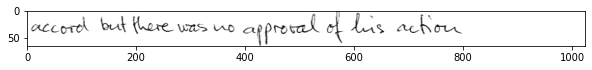

Predicted:  ['this -and it was easily stored. It hed two disadvantages. I']
Target:  ['this - and it was easily stored. It had two disadvantages. It']


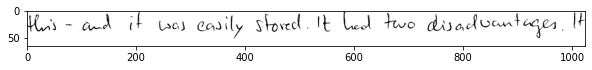

Predicted:  ['MWhen the nailing season was past, he sent Pearl bale to']
Target:  ['When the sailing season was past, he sent Pearl back to']


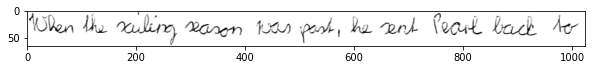

Predicted:  ['rementalating energy along the length of']
Target:  ['4ementalating energy along the length of']


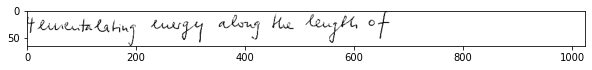

Predicted:  ['she decided freme wonld sdve ou prlens. Ths']
Target:  ['she decided Piere would solve our problems. This']


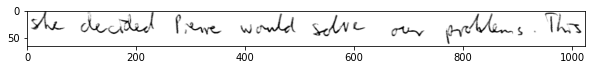

Predicted:  ['of a mother who had failed to realise that a san']
Target:  ['of a mother who had failed to realise that a son']


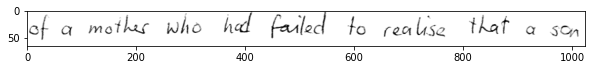

Predicted:  ['"undesmining the Health tevice\'" and']
Target:  ['"undermining the Health Service" and']


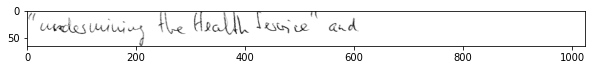

KeyboardInterrupt: ignored

In [63]:
val_dataset = tf.data.Dataset.from_generator(
    iam_generator,
    (tf.float32, tf.int32),
    (tf.TensorShape([None, None, 1]), tf.TensorShape([128]))
).batch(1)

encoder = Encoder(sequence_size=128)

for iteration_num, (images, labels) in enumerate(val_dataset):
  if iteration_num == 20:
    break

  input_lengths = tf.constant(np.full((1,), 197), dtype=tf.int32)
  preds = model2(images)
  preds_strings = encoder.idxs_to_str_batch(tf.argmax(preds, axis=2))
  target_strings = encoder.idxs_to_str_batch(labels)

  print('Predicted: ', preds_strings[:1])
  print('Target: ', target_strings[:1])
  plt.figure(figsize=(10,10))
  plt.imshow(tf.transpose(tf.squeeze(images[:1]), perm=[1,0]), cmap='gray')
  # show_imgs()
  plt.pause(1)